In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("dataset.csv")
print("Shape of dataset:", df.shape)

df.head()

Shape of dataset: (32581, 11)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,1,0.55,Y,4


In [3]:
schema = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.values,
    "n_missing": df.isnull().sum().values,
    "missing_%": (df.isnull().mean().values * 100).round(2),
    "n_unique": [df[col].nunique() for col in df.columns]
})

def role_guess(col):
    if col.lower() == "loan_status":
        return "target"
    elif schema.loc[schema['column']==col, 'n_unique'].values[0] > (0.9*len(df)):
        return "id-like"
    else:
        return "feature"

schema["role_guess"] = schema["column"].apply(role_guess)

schema

,column,dtype,n_missing,missing_%,n_unique,role_guess
0,person_age,int64,0,0.00,58,feature
1,person_income,int64,0,0.00,4295,feature
2,person_home_ownership,object,0,0.00,4,feature
3,person_emp_length,float64,895,2.75,36,feature
4,loan_intent,object,0,0.00,6,feature
5,loan_grade,object,0,0.00,7,feature
6,loan_amnt,int64,0,0.00,753,feature
7,loan_status,int64,0,0.00,2,target
8,loan_percent_income,float64,0,0.00,77,feature
9,cb_person_default_on_file,object,0,0.00,2,feature


In [4]:
# Save schema to CSV for documentation
schema.to_csv("schema.csv", index=False)
print("Schema exported to schema.csv")

Schema exported to schema.csv


In [5]:
print("Unique values in target (loan_status):", df['loan_status'].unique())
print("\nValue counts:")
print(df['loan_status'].value_counts())
print("\nPercentage distribution:")
print(df['loan_status'].value_counts(normalize=True) * 100)

Unique values in target (loan_status): [1 0]

Value counts:
loan_status
0    25473
1     7108
Name: count, dtype: int64

Percentage distribution:
loan_status
0    78.183604
1    21.816396
Name: proportion, dtype: float64


/tmp/ipython-input-1847828254.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_status', data=df, palette='Set2')


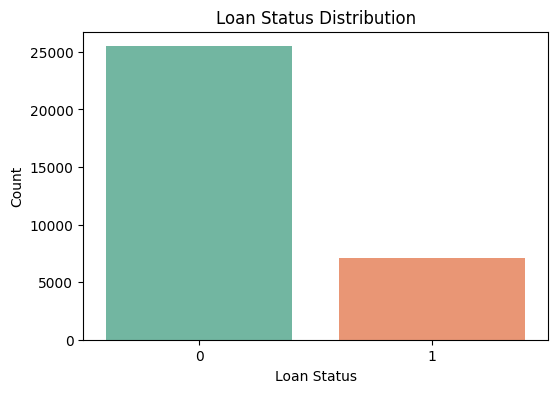

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='loan_status', data=df, palette='Set2')
plt.title("Loan Status Distribution")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

In [ ]:
# Replace 'date_column' with the actual date column name if present
# Example: df['application_date']
if 'application_date' in df.columns:
    df['application_date'] = pd.to_datetime(df['application_date'])
    df['year_month'] = df['application_date'].dt.to_period('M')

    default_rate = df.groupby('year_month')['loan_status'].mean()  # assuming loan_status is 1=default, 0=non-default

    plt.figure(figsize=(10,4))
    default_rate.plot(marker='o')
    plt.title("Default Rate Over Time")
    plt.ylabel("Default Rate")
    plt.xlabel("Year-Month")
    plt.show()

/tmp/ipython-input-3496769862.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=seg.index, x=seg.values, palette="mako")


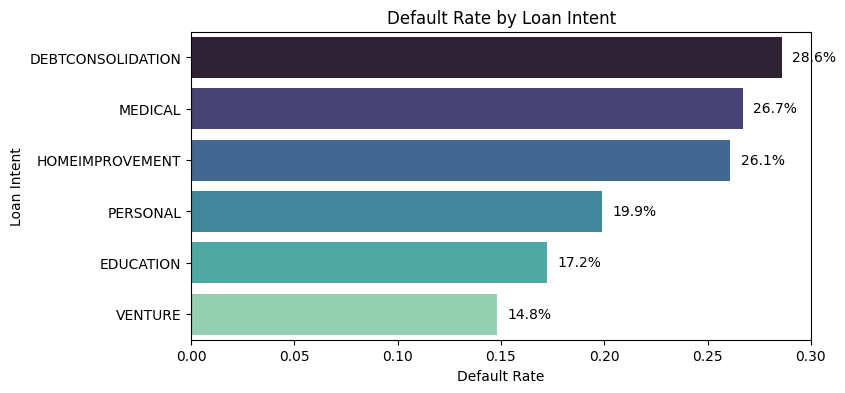

In [9]:
# Default rate by loan intent (horizontal bar)
seg = df.groupby('loan_intent')['loan_status'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(y=seg.index, x=seg.values, palette="mako")
plt.title("Default Rate by Loan Intent")
plt.xlabel("Default Rate")
plt.ylabel("Loan Intent")

# Add percentage labels on bars
for i, v in enumerate(seg.values):
    plt.text(v + 0.005, i, f"{v*100:.1f}%", va='center')

plt.show()

In [12]:
# Missing values table
missing_table = df.isnull().sum().reset_index()
missing_table.columns = ['column', 'missing_count']
missing_table['missing_%'] = (missing_table['missing_count'] / len(df) * 100).round(2)

# Sort by % of missing
missing_table = missing_table.sort_values(by='missing_%', ascending=False)

print("Top columns with missing values:")
display(missing_table.head(5))

Top columns with missing values:


,column,missing_count,missing_%
3,person_emp_length,895,2.75
1,person_income,0,0.00
0,person_age,0,0.00
2,person_home_ownership,0,0.00
4,loan_intent,0,0.00


In [13]:
missing_table.to_csv("missingness.csv", index=False)
print("Missingness table saved to missingness.csv")

Missingness table saved to missingness.csv


In [14]:

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

summary_stats = df[numeric_cols].describe().T
summary_stats["skewness"] = df[numeric_cols].skew()
summary_stats["kurtosis"] = df[numeric_cols].kurtosis()

display(summary_stats)


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
person_age,32581.0,27.734600,6.348078,20.0,23.00,26.00,30.00,144.00,2.581393,18.560825
person_income,32581.0,66074.848470,61983.119168,4000.0,38500.00,55000.00,79200.00,6000000.00,32.865349,2693.272776
person_emp_length,31686.0,4.789686,4.142630,0.0,2.00,4.00,7.00,123.00,2.614455,43.722338
loan_amnt,32581.0,9589.371106,6322.086646,500.0,5000.00,8000.00,12200.00,35000.00,1.192477,1.423565
loan_status,32581.0,0.218164,0.413006,0.0,0.00,0.00,0.00,1.00,1.364888,-0.137088
loan_percent_income,32581.0,0.170203,0.106782,0.0,0.09,0.15,0.23,0.83,1.064669,1.223687
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.0,3.00,4.00,8.00,30.00,1.661790,3.716194


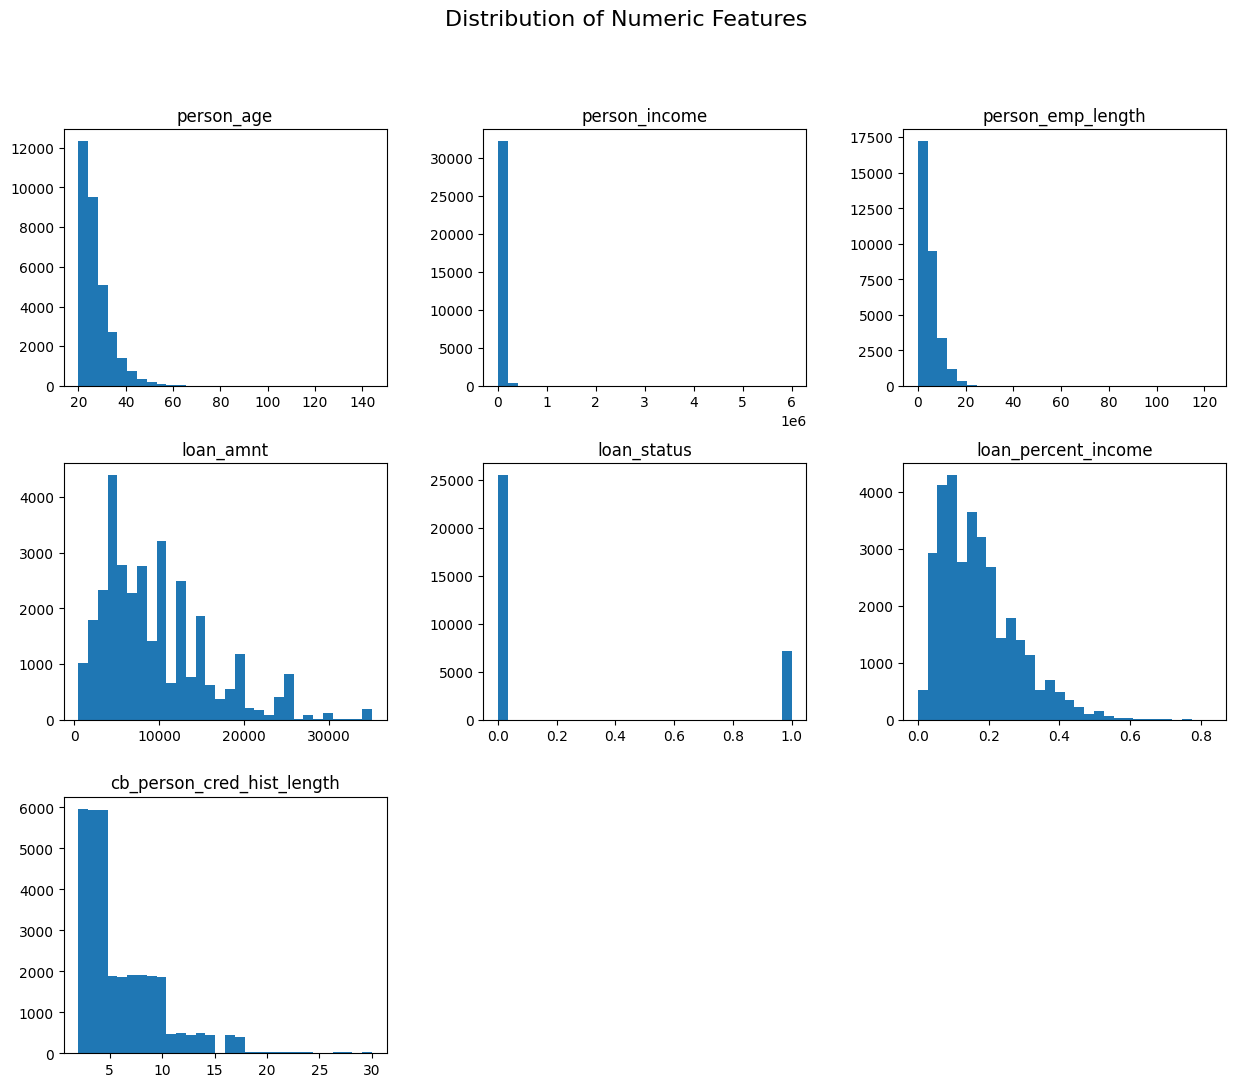

In [15]:
# Plot histograms with KDE
df[numeric_cols].hist(bins=30, figsize=(15, 12), grid=False)
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.show()


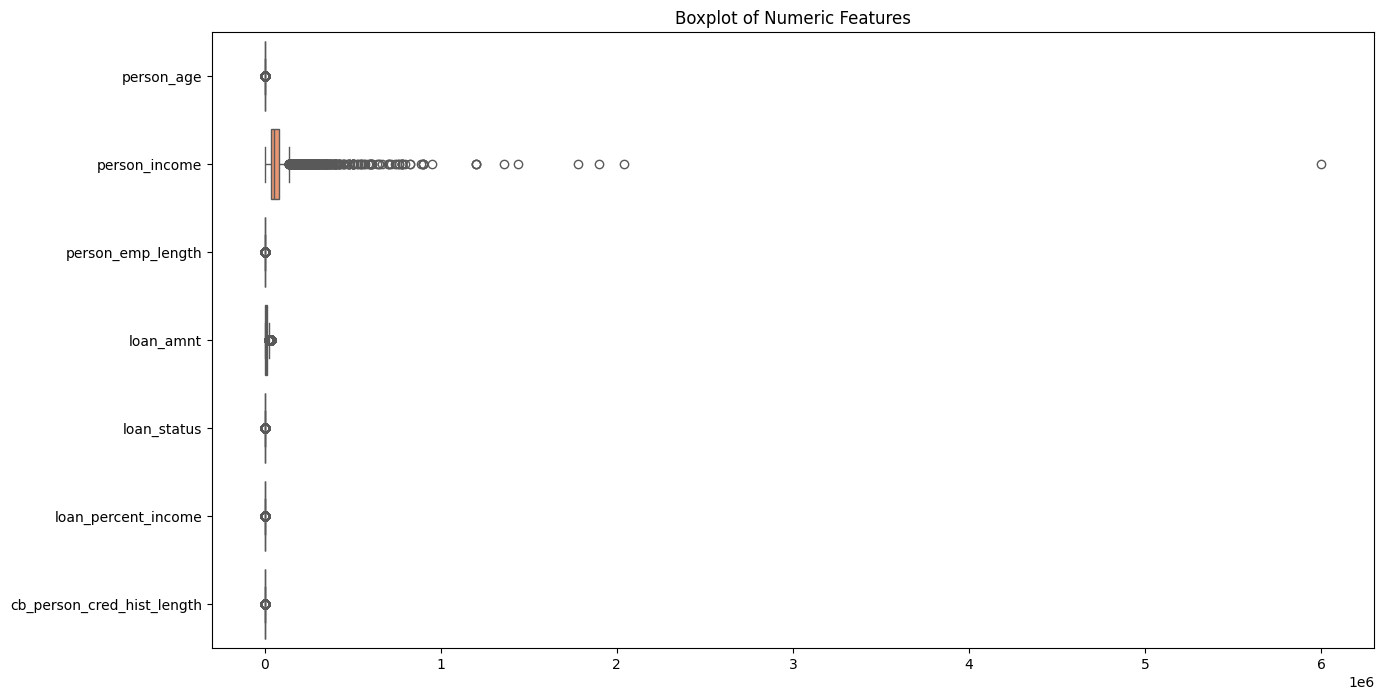

In [16]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numeric_cols], orient="h", palette="Set2")
plt.title("Boxplot of Numeric Features")
plt.show()


In [17]:
outlier_summary = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_pct = (outliers / len(df)) * 100
    outlier_summary.append([col, outliers, round(outlier_pct, 2)])

outlier_df = pd.DataFrame(outlier_summary, columns=["column", "outlier_count", "outlier_%"])
display(outlier_df.sort_values(by="outlier_%", ascending=False))


,column,outlier_count,outlier_%
4,loan_status,7108,21.82
3,loan_amnt,1689,5.18
0,person_age,1494,4.59
1,person_income,1484,4.55
6,cb_person_cred_hist_length,1142,3.51
2,person_emp_length,853,2.62
5,loan_percent_income,651,2.00


In [19]:
outlier_df.to_csv("outliers.csv", index=False)
print("Outlier summary saved to outliers.csv")

Outlier summary saved to outliers.csv


In [20]:
# Select categorical features (object or category dtype)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Categorical columns:", categorical_cols)


Categorical columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [21]:
# Frequency distribution for each categorical column
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(df[col].value_counts(normalize=True).round(3) * 100)



--- person_home_ownership ---
person_home_ownership
RENT        50.5
MORTGAGE    41.3
OWN          7.9
OTHER        0.3
Name: proportion, dtype: float64

--- loan_intent ---
loan_intent
EDUCATION            19.8
MEDICAL              18.6
VENTURE              17.6
PERSONAL             16.9
DEBTCONSOLIDATION    16.0
HOMEIMPROVEMENT      11.1
Name: proportion, dtype: float64

--- loan_grade ---
loan_grade
A    33.1
B    32.1
C    19.8
D    11.1
E     3.0
F     0.7
G     0.2
Name: proportion, dtype: float64

--- cb_person_default_on_file ---
cb_person_default_on_file
N    82.4
Y    17.6
Name: proportion, dtype: float64


In [23]:
# Cardinality (number of unique categories per column)
cardinality = pd.DataFrame({
    "column": categorical_cols,
    "n_unique": [df[col].nunique() for col in categorical_cols]
}).sort_values(by="n_unique", ascending=False)

display(cardinality)

# Rare level threshold (e.g., <2% of rows)
rare_levels = {}

for col in categorical_cols:
    freqs = df[col].value_counts(normalize=True)
    rare = freqs[freqs < 0.02].index.tolist()
    if rare:
        rare_levels[col] = rare

print("Rare levels (to group as 'Other'):")
print(rare_levels)


,column,n_unique
2,loan_grade,7
1,loan_intent,6
0,person_home_ownership,4
3,cb_person_default_on_file,2


Rare levels (to group as 'Other'):
{'person_home_ownership': ['OTHER'], 'loan_grade': ['F', 'G']}


/tmp/ipython-input-634249002.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rate.index, y=rate.values, palette="viridis")


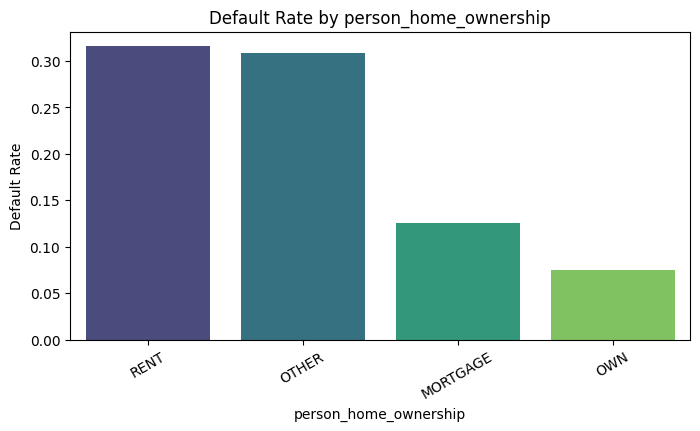


Default rates by person_home_ownership (%):
person_home_ownership
RENT        31.57
OTHER       30.84
MORTGAGE    12.57
OWN          7.47
Name: loan_status, dtype: float64


/tmp/ipython-input-634249002.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rate.index, y=rate.values, palette="viridis")


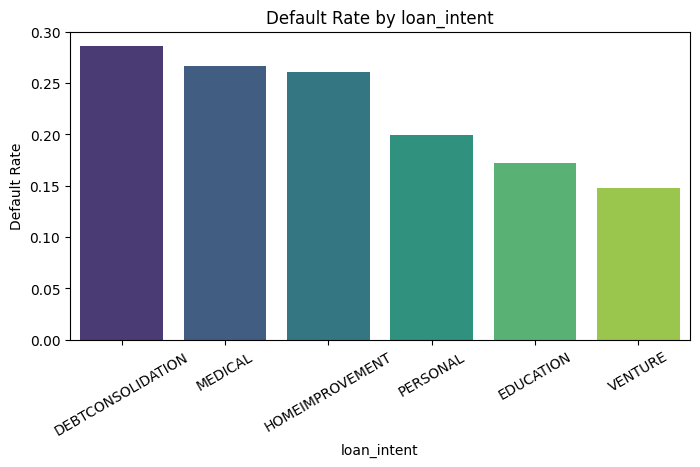


Default rates by loan_intent (%):
loan_intent
DEBTCONSOLIDATION    28.59
MEDICAL              26.70
HOMEIMPROVEMENT      26.10
PERSONAL             19.89
EDUCATION            17.22
VENTURE              14.81
Name: loan_status, dtype: float64


/tmp/ipython-input-634249002.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rate.index, y=rate.values, palette="viridis")


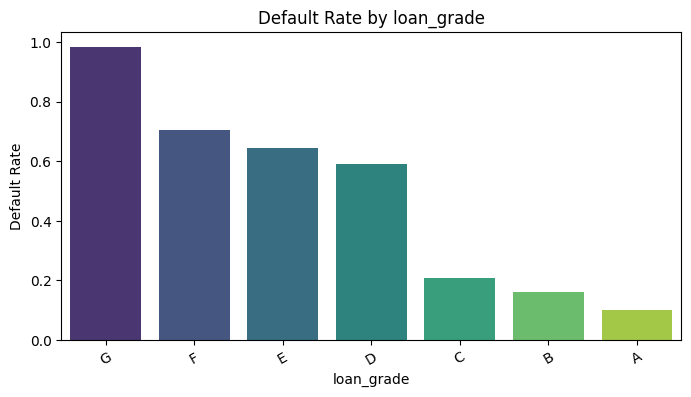


Default rates by loan_grade (%):
loan_grade
G    98.44
F    70.54
E    64.42
D    59.05
C    20.73
B    16.28
A     9.96
Name: loan_status, dtype: float64


/tmp/ipython-input-634249002.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rate.index, y=rate.values, palette="viridis")


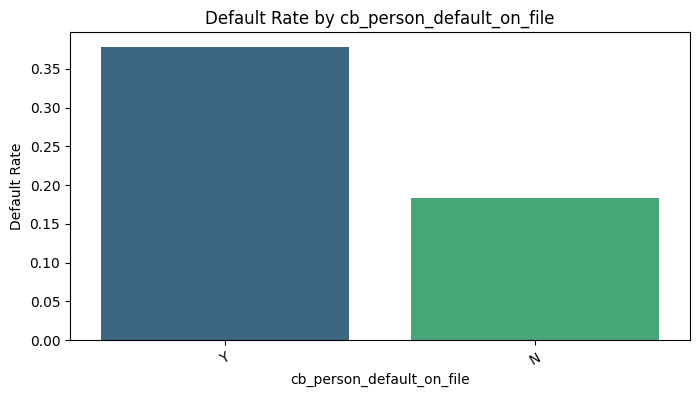


Default rates by cb_person_default_on_file (%):
cb_person_default_on_file
Y    37.81
N    18.39
Name: loan_status, dtype: float64


In [24]:
for col in categorical_cols:
    rate = df.groupby(col)['loan_status'].mean().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x=rate.index, y=rate.values, palette="viridis")
    plt.title(f"Default Rate by {col}")
    plt.ylabel("Default Rate")
    plt.xlabel(col)
    plt.xticks(rotation=30)
    plt.show()

    print(f"\nDefault rates by {col} (%):")
    print((rate*100).round(2))


In [25]:
cardinality.to_csv("cardinality.csv", index=False)
print("Cardinality table saved to cardinality.csv")


Cardinality table saved to cardinality.csv


/tmp/ipython-input-697106541.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="loan_status", y=col, data=df, palette="Set2")


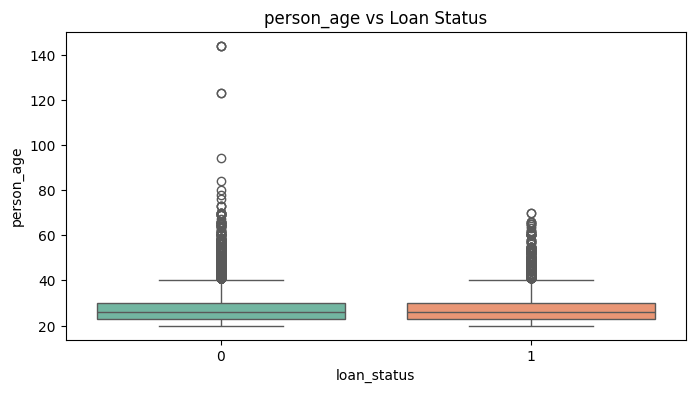

/tmp/ipython-input-697106541.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="loan_status", y=col, data=df, palette="Set2")


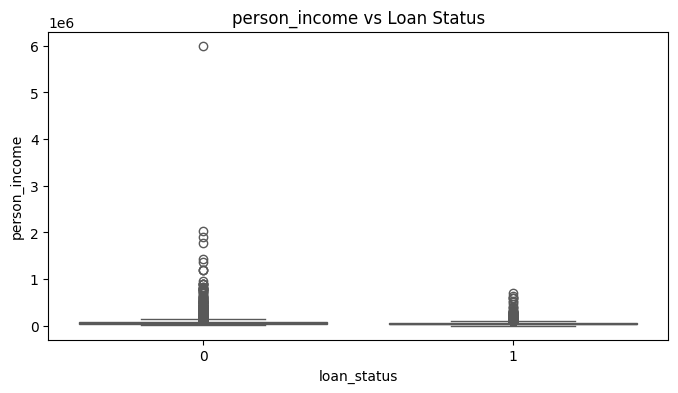

/tmp/ipython-input-697106541.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="loan_status", y=col, data=df, palette="Set2")


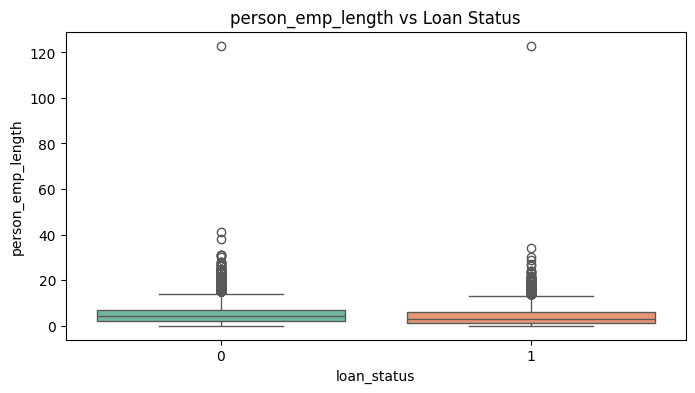

/tmp/ipython-input-697106541.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="loan_status", y=col, data=df, palette="Set2")


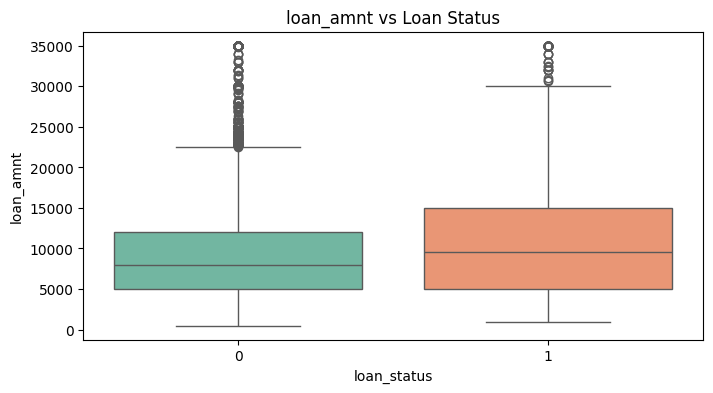

/tmp/ipython-input-697106541.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="loan_status", y=col, data=df, palette="Set2")


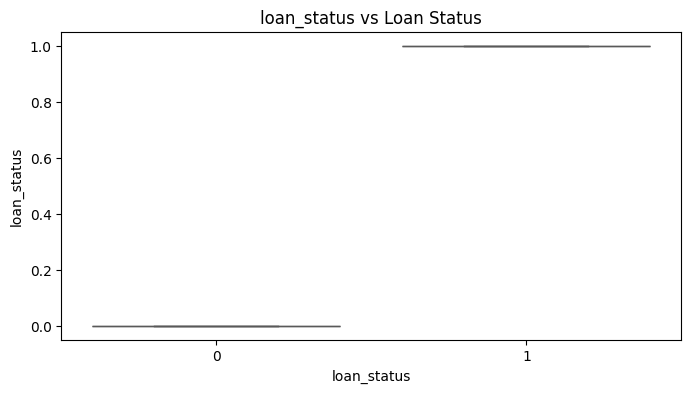

/tmp/ipython-input-697106541.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="loan_status", y=col, data=df, palette="Set2")


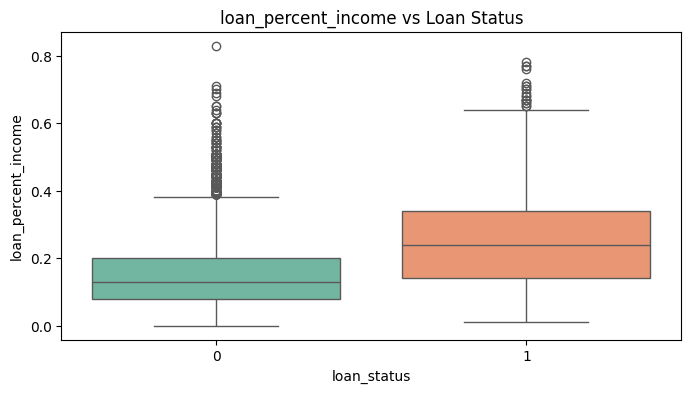

/tmp/ipython-input-697106541.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="loan_status", y=col, data=df, palette="Set2")


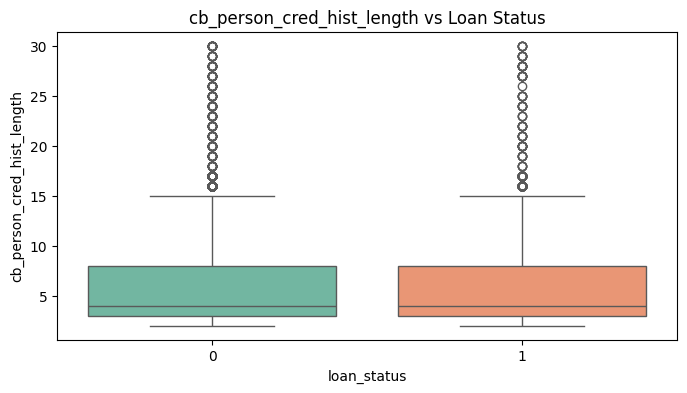

In [26]:
# Loop through numeric features
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x="loan_status", y=col, data=df, palette="Set2")
    plt.title(f"{col} vs Loan Status")
    plt.show()

In [27]:
from scipy.stats import mannwhitneyu

num_target_stats = []
for col in numeric_cols:
    group0 = df[df['loan_status']==0][col].dropna()
    group1 = df[df['loan_status']==1][col].dropna()
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    num_target_stats.append([col, p])

num_target_df = pd.DataFrame(num_target_stats, columns=["feature", "p_value"])
display(num_target_df.sort_values("p_value"))


,feature,p_value
1,person_income,0.000000e+00
4,loan_status,0.000000e+00
5,loan_percent_income,0.000000e+00
2,person_emp_length,1.501798e-67
3,loan_amnt,5.792273e-52
0,person_age,1.740007e-09
6,cb_person_cred_hist_length,1.769935e-05


/tmp/ipython-input-26188223.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="loan_status", y=col, data=df, palette="Set2")


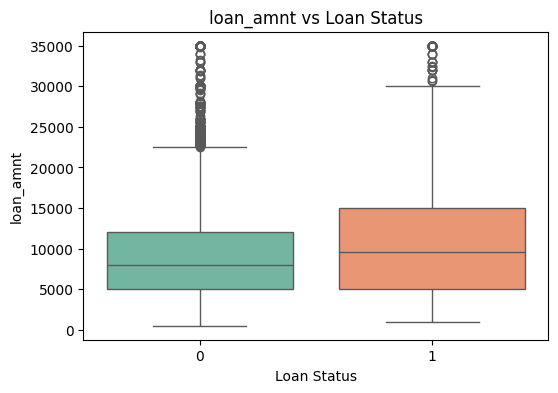

/tmp/ipython-input-26188223.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="loan_status", y=col, data=df, palette="Set2")


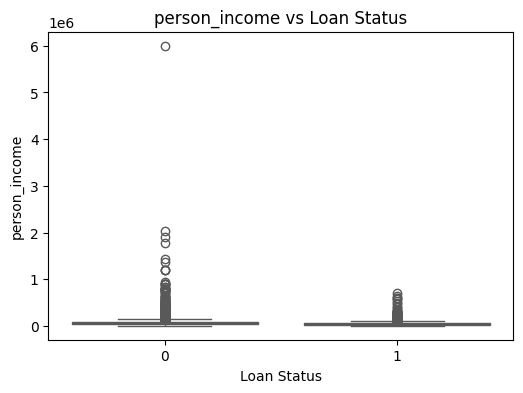

In [29]:
# Pick top numeric features relevant in credit scoring
key_numeric = ["loan_amnt", "person_income"]  # adjust if columns differ in your dataset

for col in key_numeric:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="loan_status", y=col, data=df, palette="Set2")
    plt.title(f"{col} vs Loan Status")
    plt.xlabel("Loan Status")
    plt.ylabel(col)
    plt.show()

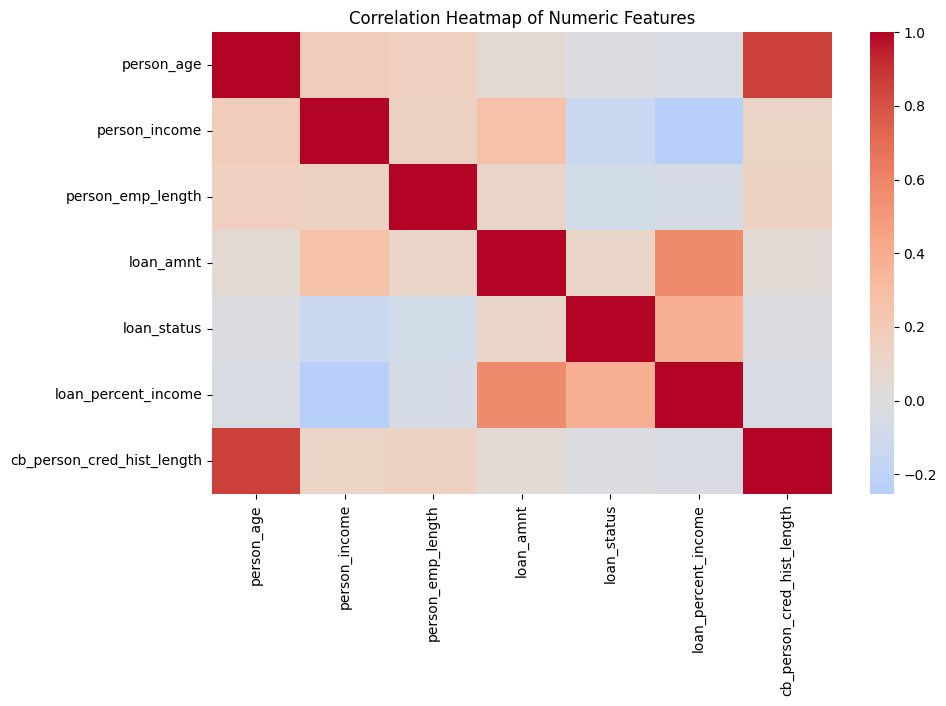

In [31]:
# Correlation matrix for numeric features
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

In [32]:
# Find pairs with correlation above threshold (e.g., 0.8)
threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j]) > threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i,j]
            high_corr_pairs.append((col1, col2, corr_val))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature1", "Feature2", "Correlation"])
display(high_corr_df.sort_values(by="Correlation", key=abs, ascending=False))


,Feature1,Feature2,Correlation
0,cb_person_cred_hist_length,person_age,0.859133


,loan_status
loan_status,1.000000
loan_percent_income,0.379366
loan_amnt,0.105376
cb_person_cred_hist_length,-0.015529
person_age,-0.021629
person_emp_length,-0.082489
person_income,-0.144449


Suspected leakage features: ['loan_status']
